<a href="https://colab.research.google.com/github/ProvenDruid/metaparams/blob/main/metaparams_exercise_wineModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for timing computations
import time

# for data visualization
import matplotlib.pyplot as plt
from IPython import display
from matplotlib_inline.backend_inline import set_matplotlib_formats

In [ ]:
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
datao = pd.read_csv(url,sep=';')
data = datao[datao['total sulfur dioxide']<200] # drop a few outliers

# z-score all columns except for quality
cols2zscore = data.keys()
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)
#data2=data.drop(columns=['quality','residual sugar'])
data2=data.drop(columns=['residual sugar'])
type(data2.keys())

<ipython-input-4-aff78fea0d75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[cols2zscore] = data[cols2zscore].apply(stats.zscore)


pandas.core.indexes.base.Index

In [ ]:
data['residual sugar']

0      -0.452579
1       0.049020
2      -0.165951
3      -0.452579
4      -0.452579
          ...   
1594   -0.380922
1595   -0.237608
1596   -0.165951
1597   -0.380922
1598    0.765590
Name: residual sugar, Length: 1597, dtype: float64

In [ ]:
print(dataT.shape)
print(type(dataT))
dataT

NameError: name 'dataT' is not defined

In [ ]:
np_data=data2.to_numpy()
dataT2=torch.from_numpy(np_data).float()
print(dataT2.shape)
print(type(dataT2))
dataT2

torch.Size([1597, 11])
<class 'torch.Tensor'>


tensor([[-0.5284,  0.9607, -1.3918,  ..., -0.5802, -0.9593, -0.7866],
        [-0.2987,  1.9666, -1.3918,  ...,  0.1278, -0.5833, -0.7866],
        [-0.2987,  1.2960, -1.1860,  ..., -0.0492, -0.5833, -0.7866],
        ...,
        [-1.1600, -0.1012, -0.7228,  ...,  0.5409,  0.5446,  0.4535],
        [-1.3896,  0.6533, -0.7743,  ...,  0.3048, -0.2074, -0.7866],
        [-1.3322, -1.2189,  1.0268,  ...,  0.0098,  0.5446,  0.4535]])

In [ ]:
dataT3=torch.tensor(data.values).float()
print(dataT3.shape)
print(type(dataT3))
dataT3

In [ ]:
# convert from pandas dataframe to tensor
dataTensor  = torch.tensor( data2.values ).float()
sugarTarget = torch.tensor( data['residual sugar'].values ).float()
print(sugarTarget.shape)
sugarTarget = sugarTarget[:,None] # transform to matrix
print(sugarTarget.shape)


torch.Size([1597])
torch.Size([1597, 1])


In [ ]:
sugarTarget

tensor([[-0.4526],
        [ 0.0490],
        [-0.1660],
        ...,
        [-0.1660],
        [-0.3809],
        [ 0.7656]])

In [ ]:
sugarTarget

tensor([[-0.4526],
        [ 0.0490],
        [-0.1660],
        ...,
        [-0.1660],
        [-0.3809],
        [ 0.7656]])

In [ ]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataTensor, sugarTarget, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = TensorDataset(train_data,train_labels)
test_dataDataset  = TensorDataset(test_data,test_labels)

# finally, translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_dataDataset,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])

In [ ]:
# check values in sugar
plt.plot(sugarTarget,'s')
plt.xlabel('Data observation')
plt.ylabel('Sugar (norm.)')
plt.show()

In [ ]:
# create a class for the model

class ANNwine(nn.Module):
  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(11,16)

    ### hidden layers
    self.fc1 = nn.Linear(16,32)
    self.fc2 = nn.Linear(32,32)

    ### output layer
    self.output = nn.Linear(32,1)

  # forward pass
  def forward(self,x):
    x = F.relu( self.input(x) )
    x = F.relu( self.fc1(x) ) # fully connected
    x = F.relu( self.fc2(x) )
    return self.output(x)

In [ ]:
# a function that trains the model

# global parameter
numepochs = 1000

def trainTheModel():

  # loss function and optimizer
  lossfun = nn.MSELoss()
  optimizer = torch.optim.SGD(winenet.parameters(),lr=.01)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    winenet.train()

    # loop over training data batches
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = winenet(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

    # and get average losses across the batches
    trainLoss[epochi] = np.mean(batchLoss)

    # test accuracy
    winenet.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = winenet(X)
    testLoss[epochi] = lossfun(yHat,y).item()

  # function output
  return trainLoss,testLoss

In [ ]:
# create and train a model
winenet = ANNwine()
trainLoss,testLoss = trainTheModel()

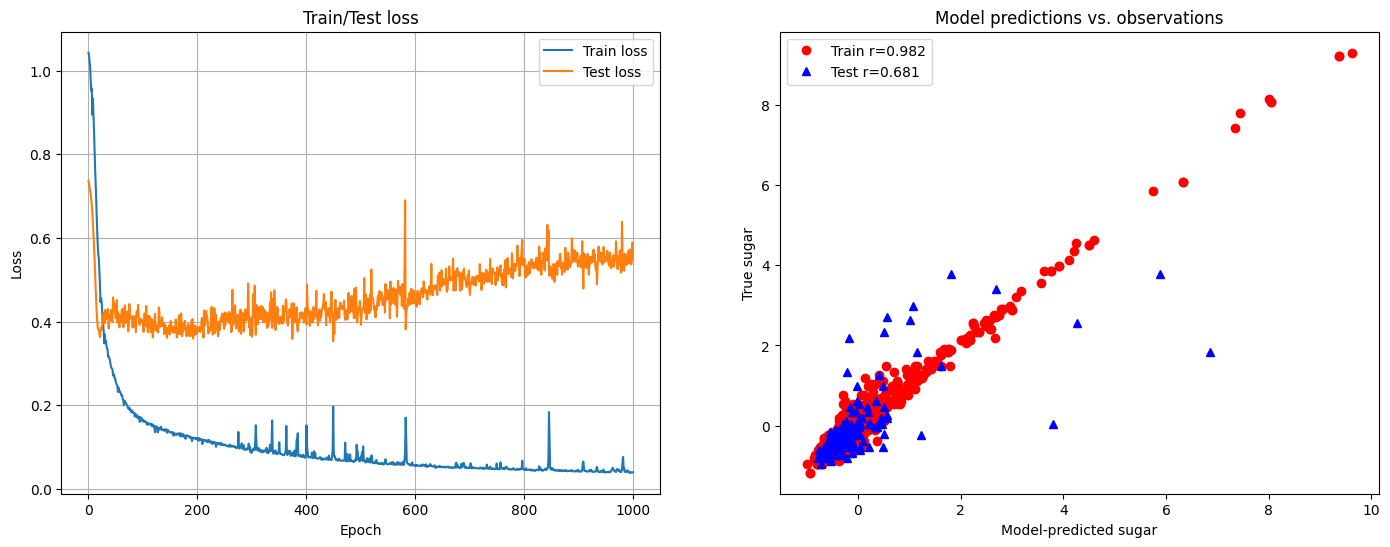

In [ ]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(17,6))

ax[0].plot(trainLoss,label='Train loss')
ax[0].plot(testLoss,label='Test loss')
ax[0].set_title('Train/Test loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].grid()


# show predictions and real values
yHatTrain = winenet(train_data)
yHatTest  = winenet(test_data)

ax[1].plot(yHatTrain.detach(),train_labels,'ro')
ax[1].plot(yHatTest.detach(),test_labels,'b^')
ax[1].set_xlabel('Model-predicted sugar')
ax[1].set_ylabel('True sugar')
ax[1].set_title('Model predictions vs. observations')

# correlations between predictions and outputs
corrTrain = np.corrcoef(yHatTrain.detach().T,train_labels.T)[1,0]
corrTest  = np.corrcoef(yHatTest.detach().T, test_labels.T)[1,0]
ax[1].legend([ f'Train r={corrTrain:.3f}',f'Test r={corrTest:.3f}' ])

plt.show()

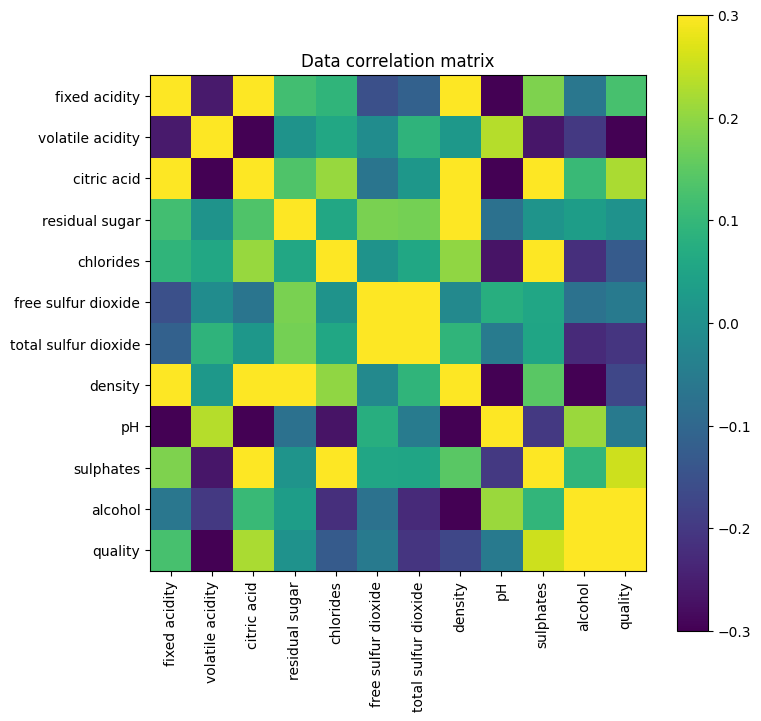

In [ ]:
# Inspect the correlation matrix
fig = plt.figure(figsize=(8,8))

plt.imshow(np.corrcoef(data.T),vmin=-.3,vmax=.3)
plt.xticks(range(len(data.keys())),labels=data.keys(),rotation=90)
plt.yticks(range(len(data.keys())),labels=data.keys())
plt.colorbar()
plt.title('Data correlation matrix')
plt.show()